In [1]:
userID = 'adamranson'
expID = '2022-02-07_03_ESPM039'
expID = '2023-02-24_02_ESMT116' # lights off eye pos calib
expID = '2023-04-18_01_ESMT124'
#expID = '2023-02-24_01_ESMT116'

In [2]:
import pickle
import os
import organise_paths
import preprocess_cam
import preprocess_bv
import crop_videos
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import shutil
from scipy.optimize import curve_fit

import cv2
from io import BytesIO
#import IPython.display as display
#from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Label, Image as ImageWidget
#import ipywidgets as widgets
from PIL import Image
import threading
from scipy.ndimage import median_filter

def polynomial_2D(x_y, a, b, c, d, e, f):
    x, y = x_y
    return a * x**2 + b * y**2 + c * x * y + d * x + e * y + f

animalID, remote_repository_root, processed_root, exp_dir_processed, exp_dir_raw = organise_paths.find_paths(userID, expID)
exp_dir_processed_recordings = os.path.join(exp_dir_processed,'recordings')
exp_dir_processed_cut = os.path.join(exp_dir_processed,'cut')
video_path_left = os.path.join(exp_dir_processed,(expID+'_eye1_left.avi'))
video_path_right = os.path.join(exp_dir_processed,(expID+'_eye1_right.avi'))

In [3]:
# check prerequisite processing has been done and load required files
# eyetracking frames have been timestamped?
if os.path.exists(os.path.join(exp_dir_processed_recordings,'eye_frame_times.npy')):
    # load the eyetracking frames timestamps
    frame_times = np.load(os.path.join(exp_dir_processed_recordings,'eye_frame_times.npy'))
else:
    # make folder for processed data
    os.makedirs(exp_dir_processed, exist_ok = True)
    os.makedirs(exp_dir_processed_recordings, exist_ok = True)

    # generate the eyetracking frame timestamps
    preprocess_cam.preprocess_cam_run(userID, expID)
    # load the eyetracking frames eye stamps
    frame_times = np.load(os.path.join(exp_dir_processed_recordings,'eye_frame_times.npy'))

# stimulus information
if os.path.exists(os.path.join(exp_dir_processed, expID + '_all_trials.csv')):
    # load stim info
    all_trials = pd.read_csv(os.path.join(exp_dir_processed, expID + '_all_trials.csv'))
else:
    # generate / load stim info file
    preprocess_bv.run_preprocess_bv(userID,expID)
    all_trials = pd.read_csv(os.path.join(exp_dir_processed, expID + '_all_trials.csv'))

# check if cropped videos are in the processed data directory and if not try to copy from the remote repos
if (not os.path.isfile(video_path_left)) or (not os.path.isfile(video_path_right)):
    try:
        print('Copying eye videos - is is a one-off not required in future')
        shutil.copyfile(os.path.join(exp_dir_raw, (expID+'_eye1_left.avi')),video_path_left)
        shutil.copyfile(os.path.join(exp_dir_raw, (expID+'_eye1_right.avi')),video_path_right)
        print('Done!')
    except:
        # produce cropped videos
        crop_videos.crop_videos(userID, expID)

cap_L = cv2.VideoCapture(video_path_left)
cap_R = cv2.VideoCapture(video_path_right)  

cap_L.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap_L.read()
frame = frame[:,:,0]
frame_size = np.array(frame.shape)


In [4]:
x=0
num_stims = len(all_trials['stim'].unique())
trial_indices = all_trials.loc[(all_trials['stim'] == 1)].index

all_stim_pos = np.full([num_stims,2],0)

# stim times are:
# 0 - 1 sec - black
# 1 - 2 sec - black with white square

# preallocate for average frames of each condition
# frame_size = [200,200]
mean_pre = np.full(np.append(num_stims,frame_size),0)
mean_post = np.full(np.append(num_stims,frame_size),0)
mean_diff = np.full(np.append(num_stims,frame_size),0)

for iStim in range(num_stims):
    trial_indices = all_trials.loc[(all_trials['stim'] == iStim+1)].index
    # store x an d y pos
    all_stim_pos[iStim,0] = all_trials.loc[trial_indices[0],'F2_x']
    all_stim_pos[iStim,1] = all_trials.loc[trial_indices[0],'F2_y']
    # iterate through trials of stim type
    # preallocate for space for trials within stim cond
    mean_pre_trials = np.full(np.append(len(trial_indices),frame_size),0)
    mean_post_trials = np.full(np.append(len(trial_indices),frame_size),0)
    for iTrial in range(len(trial_indices)):

        # find pre trial frames
        trial_onset_time = all_trials.loc[trial_indices[iTrial],'time']
        preframes = np.where((frame_times >= trial_onset_time + 0.4) & (frame_times <= trial_onset_time + 0.8))
        preframes = preframes[0]
        postframes = np.where((frame_times >= trial_onset_time + 1.2) & (frame_times <= trial_onset_time + 1.8))
        postframes = postframes[0]

        # load the pre frames
        pre_all_frames = np.full(np.append(len(preframes),frame_size),0)
        for iFrame in range(len(preframes)):
            cap_L.set(cv2.CAP_PROP_POS_FRAMES, int(preframes[iFrame]))
            ret, frame = cap_L.read()
            frame = np.sum(frame,axis=2)
            # crop frame to eye
            # frame = frame[200:400,350:550]
            pre_all_frames[iFrame,:,:] = frame

        # load the post frames
        post_all_frames = np.full(np.append(len(postframes),frame_size),0)
        for iFrame in range(len(postframes)):
            cap_L.set(cv2.CAP_PROP_POS_FRAMES, int(postframes[iFrame]))
            ret, frame = cap_L.read()
            frame = np.sum(frame,axis=2)
            # crop frame to eye
            # frame = frame[200:400,350:550]
            post_all_frames[iFrame,:,:] = frame

        # store mean of the pre and post trial frames
        mean_pre_trials[iTrial,:,:] = np.mean(pre_all_frames,axis = 0)
        mean_post_trials[iTrial,:,:] = np.mean(post_all_frames,axis = 0)

    # store the mean of the pre and post trials
    mean_pre[iStim,:,:] = np.mean(mean_pre_trials,axis=0)
    mean_post[iStim,:,:] = np.mean(mean_post_trials,axis=0)
    mean_diff[iStim,:,:] = mean_post[iStim,:,:] - mean_pre[iStim,:,:]

# display each stim cond
sorted_indices = np.lexsort((all_stim_pos[:, 0], all_stim_pos[:, 1]))

all_stim_pos = all_stim_pos[sorted_indices,:]
mean_diff = mean_diff[sorted_indices,:,:]

mean_diff = mean_diff - np.min(np.ravel(mean_diff))

# x = 0
# fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(18, 18))

# for iStim in range(num_stims):
#     im2show = np.random.rand(10,10)
#     img = axes.flatten()[iStim].imshow(mean_diff[iStim,:,:],clim=(0,15))
#     plt.colorbar(mappable=img, ax=iStim) 
#     # axes[iStim].set_title(str(iStim))
#     #axes.flatten()[iStim].imshow(im2show)


# # for i, ax in enumerate(axes.flatten()[1:], 1):
# #     ax.set_title(f'Subplot {i}')

# plt.show()
# x = 0
# im2show = np.random.rand(10,10)
# plt.imshow(im2show)
# plt.show()
# plt.imshow(np.random.rand(10,10))
# plt.show()

In [5]:
# dynamically find the pupil position with max over frames
max_frame = np.max(mean_diff,axis=0)
max_frame = max_frame - np.min(mean_diff[:])
max_frame = max_frame.astype(np.uint8)
thres = np.percentile(np.ravel(max_frame), 99.9)
# threshold the images to find valid points
ret, binary = cv2.threshold(max_frame, thres, 1, cv2.THRESH_BINARY)
# Calculate the moments of the binary image
M = cv2.moments(binary)
# Calculate the x and y coordinates of the center of mass
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
# Print the coordinates of the center of mass
print('Center of mass coordinates: ({}, {})'.format(cx, cy))
# Crop the frame to be a 200 x 200 centred on the predicted eye position
mean_diff_cropped = mean_diff[:,cy-100:cy+100,cx-100:cx+100]
# for each cropped frame check if it has a stim reflection
# set threshold for reflection
ref_thres = np.percentile(np.ravel(mean_diff), 99.99)
all_pos_data = np.empty((0,4),float)
for iStim in range(num_stims):
    stim_frame = mean_diff_cropped[iStim,:,:].astype(np.uint8)
    ret, thresh = cv2.threshold(stim_frame, ref_thres, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours)>0:
        # plt.imshow(stim_frame)
        # plt.show()
        # plt.imshow(thresh)
        # plt.show()
        # if a reflection is found
        # Compute the mean color (brightness) of each contour
        mean_colors = []
        for contour in contours:
            mask = np.zeros_like(stim_frame)
            cv2.drawContours(mask, [contour], 0, 255, -1)
            mean_color = cv2.mean(stim_frame, mask=mask)[:3]
            mean_colors.append(np.mean(mean_color))
        # Get the index of the contour with the highest mean color value
        largest_index = np.argmax(mean_colors)
        largest_contour = contours[largest_index]
        # add the midpoint of this island of pixels as a data point 
        M = cv2.moments(largest_contour)
        if M['m00'] > 0:
            # make sure it is a valid contour
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            all_pos_data = np.append(all_pos_data,np.array([[cx,cy,all_stim_pos[iStim,0],all_stim_pos[iStim,1]]]),axis=0)

# all_pos_data rows are stim positions and columns are [reflection x, reflection y, stim pos x, stim pos y]
x=0
# do fit
# Fit the polynomial function to the data
popt_azimuth, _ = curve_fit(polynomial_2D, (all_pos_data[:, 0], all_pos_data[:, 1]), all_pos_data[:, 2])
popt_elevation, _ = curve_fit(polynomial_2D, (all_pos_data[:, 0], all_pos_data[:, 1]), all_pos_data[:, 3])

def pixel_to_angle(x, y):
    azimuth = polynomial_2D((x, y), *popt_azimuth)
    elevation = polynomial_2D((x, y), *popt_elevation)
    return azimuth, elevation

azimuth, elevation = pixel_to_angle(136, 115)
print(f"Pixel position corresponds to azimuth = {azimuth:.2f}° and elevation = {elevation:.2f}°")

# make a 

Center of mass coordinates: (526, 198)
Pixel position corresponds to azimuth = -90.59° and elevation = -12.42°


In [6]:
# plot the fit
import numpy as np

# Assuming the frame has dimensions (height, width)
height = 200
width = 200

# Create a grid of x and y coordinates
x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))

def pixel_to_angle_vectorized(x_grid, y_grid):
    azimuth = polynomial_2D((x_grid, y_grid), *popt_azimuth)
    elevation = polynomial_2D((x_grid, y_grid), *popt_elevation)
    return azimuth, elevation

# Apply the pixel_to_angle_vectorized function to the entire grid
azimuth_matrix, elevation_matrix = pixel_to_angle_vectorized(x_coords, y_coords)
x = 0
# Now, azimuth_matrix and elevation_matrix contain the azimuth and elevation values for each x and y position in the frame


In [ ]:
# iStim = 21
# plt.imshow(mean_diff[iStim,:,:],clim=(10,25))
# plt.colorbar()
# plt.show()

# x = 0
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 10))

for iStim in range(num_stims):
    #im2show = np.random.rand(10,10)
    axes.flatten()[iStim].imshow(mean_diff[iStim,:,:],clim=(5,15))
    axes.flatten()[iStim].set_xticks([])
    axes.flatten()[iStim].set_yticks([])
    #plt.show()
    #plt.colorbar(mappable=img, ax=iStim) 

NameError: name 'im2show' is not defined

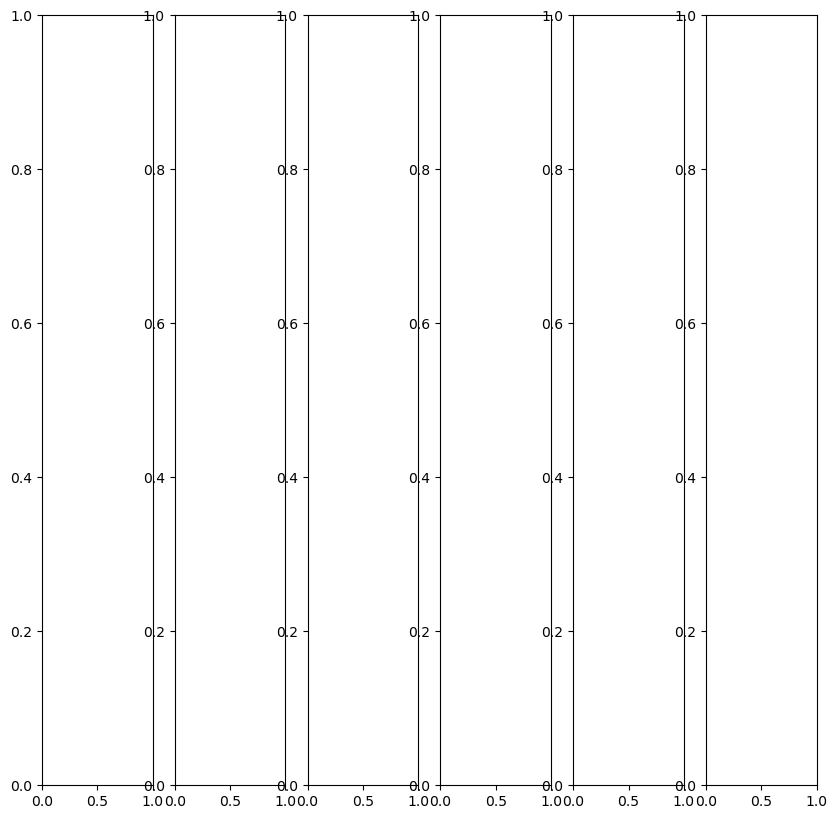

In [7]:
# find pre trial frames
iTrail = 3
trial_onset_time = all_trials.loc[iTrail,'time']
preframes = np.where((frame_times >= trial_onset_time + 0) & (frame_times <= trial_onset_time + 1))
preframes = preframes[0]
postframes = np.where((frame_times >= trial_onset_time + 1) & (frame_times <= trial_onset_time + 2))
postframes = postframes[0]

fig, axes = plt.subplots(nrows=1, ncols=len(preframes), figsize=(10, 10))
for iFrame in range(len(preframes)):
    axes.flatten()[iFrame].imshow(im2show)
    plt.imshow(im2show)
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def polynomial_2D(x_y, a, b, c, d, e, f):
    x, y = x_y
    return a * x**2 + b * y**2 + c * x * y + d * x + e * y + f

# Example pixel positions (x, y) in the image plane
pixel_positions = np.array([
    [100, 120],
    [200, 100],
    [300, 200],
    [400, 300],
    [500, 400],
])

# Corresponding object positions (azimuth, elevation) in degrees
object_positions = np.array([
    [30, 20],
    [60, 10],
    [90, 30],
    [120, 40],
    [150, 50],
])

# Fit the polynomial function to the data
popt_azimuth, _ = curve_fit(polynomial_2D, (pixel_positions[:, 0], pixel_positions[:, 1]), object_positions[:, 0])
popt_elevation, _ = curve_fit(polynomial_2D, (pixel_positions[:, 0], pixel_positions[:, 1]), object_positions[:, 1])

def pixel_to_angle(x, y):
    azimuth = polynomial_2D((x, y), *popt_azimuth)
    elevation = polynomial_2D((x, y), *popt_elevation)
    return azimuth, elevation

# Example: Convert pixel position (350, 250) to azimuth and elevation angles
azimuth, elevation = pixel_to_angle(350, 250)
print(f"Pixel position (350, 250) corresponds to azimuth = {azimuth:.2f}° and elevation = {elevation:.2f}°")
